<a href="https://colab.research.google.com/github/naralakamsani/unsupervised_learning/blob/main/bike_sharing_demand_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import time

#Data

[Bike Sharing Demand](https://www.kaggle.com/competitions/bike-sharing-demand/overview)


##Load Data

In [ ]:
!curl -o bike_sharing_demand.csv https://raw.githubusercontent.com/naralakamsani/supervised_learning/main/data/bike_sharing/train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  633k  100  633k    0     0  1742k      0 --:--:-- --:--:-- --:--:-- 1739k


In [ ]:
df = pd.read_csv("bike_sharing_demand.csv")

In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Encode Labeled Data

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['weekday_name'] = df['datetime'].dt.weekday

df = df.drop(columns=["datetime", "casual","registered","holiday"])

In [ ]:
df.head()

,season,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,weekday_name
0,1,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,5
1,1,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,5
2,1,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,5
3,1,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,5
4,1,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        10886 non-null  int64  
 1   workingday    10886 non-null  int64  
 2   weather       10886 non-null  int64  
 3   temp          10886 non-null  float64
 4   atemp         10886 non-null  float64
 5   humidity      10886 non-null  int64  
 6   windspeed     10886 non-null  float64
 7   count         10886 non-null  int64  
 8   year          10886 non-null  int64  
 9   month         10886 non-null  int64  
 10  day           10886 non-null  int64  
 11  hour          10886 non-null  int64  
 12  weekday_name  10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


## Split Data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['count'],axis=1), df['count'], test_size=0.2, random_state=1)

In [ ]:
print("Train data size:", len(x_train))
print("Test data size:", len(x_test))

Train data size: 8708
Test data size: 2178


## Scale Data

In [ ]:
x_train_not_scaled = x_train
x_test_not_scaled = x_test

scaler =  StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)

In [ ]:
x_train.head()

,season,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday_name
0,0.441703,0.686255,0.906197,0.990915,0.971847,1.406609,0.875327,-1.003912,0.427886,-1.085004,-0.797314,-0.010314
1,-1.353141,-1.457184,0.906197,0.567489,0.881658,-0.463818,0.509680,-1.003912,-1.024986,1.646535,-1.664684,0.987621
2,0.441703,0.686255,-0.665748,0.567489,0.432493,1.354653,0.509680,-1.003912,0.427886,0.918125,-0.652752,-1.507217
3,-0.455719,0.686255,-0.665748,-0.067649,-0.017266,0.263570,-0.464832,0.996103,-0.443837,1.464433,-1.375561,0.488654
4,-1.353141,-1.457184,-0.665748,-1.337927,-1.095974,0.679221,-1.560954,0.996103,-1.315560,-1.085004,-1.230999,0.987621


# Plots

## Learning Curve

In [ ]:
def plot_learning_curve(estimator, title, x, y, cv=5, n_jobs=-1, train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], scoring='neg_root_mean_squared_error'):
    plt.figure()
    plt.title(title)

    plt.xlabel("Training examples")
    plt.ylabel(" RMSE")
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross validation RMSE")

    plt.legend(loc="best")
    return plt

## Validation Curve

In [ ]:
def plot_validation_curve(estimator, title, x, y, param_name, param_range, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error'):
    plt.figure()
    plt.title(title)

    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    train_scores, test_scores = validation_curve(estimator, x, y, scoring=scoring, cv=cv, n_jobs=n_jobs,param_name=param_name, param_range=param_range)

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training Negitive RMSE")
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross validation RMSE")

    plt.legend(loc="best")
    return plt

## Validation Barplot

In [ ]:
def plot_validation_barplot(title, x, y, parameters, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error'):
    plt.figure()
    plt.title(title)

    plt.ylabel('RMSE')
    plt.xlabel("hidden_layer_sizes")

    train_scores = []
    test_scores = []

    for parameter in parameters:
      estimator = MLPRegressor(random_state=1, hidden_layer_sizes = parameter)
      scores = cross_validate(estimator, x, y, cv=cv, scoring=scoring, n_jobs=n_jobs, return_train_score=True)
      train_scores.append(-np.mean(scores["train_score"]))
      test_scores.append(-np.mean(scores["test_score"]))

    plt.grid()

    bar_width = 0.35
    index = np.arange(len(parameters))

    bar1 = plt.bar(index, train_scores, bar_width, label='Training RMSE', alpha=0.7)
    bar2 = plt.bar(index + bar_width, test_scores, bar_width, label='Cross validation RMSE', alpha=0.7)

    plt.xticks(index + bar_width*2/3, parameters)
    plt.legend(loc="best")

    return plt

## Loss Curve

In [ ]:
def plot_loss_curve(estimator, title, x, y):
    plt.figure()
    plt.title(title)

    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    estimator.fit(x, y)

    plt.grid()

    plt.plot(estimator.loss_curve_)

    return plt

## Model Comparison Plot

In [ ]:
def compare_models():
    models = ['Decision Tree', 'Neural Network', 'Boosting', 'SVM', 'KNN']

    estimators = [DecisionTreeRegressor(random_state=1, max_depth=13),
                  MLPRegressor(random_state=1, hidden_layer_sizes=(300,300), learning_rate_init=0.01),
                  GradientBoostingRegressor(random_state=1, n_estimators=250, subsample=0.7),
                  SVR(kernel ='rbf', C=1000),
                  KNeighborsRegressor(n_neighbors=12, p=1)
                  ]

    training_times = []
    inference_times = []
    rmses = []

    for estimator in estimators:
        start_time = time.time()
        estimator.fit(x_train, y_train)
        elapsed_time = time.time() - start_time
        training_times.append(elapsed_time)

        start_time = time.time()
        predictions = estimator.predict(x_test)
        elapsed_time = time.time() - start_time
        inference_times.append(elapsed_time)

        predictions[predictions<0] = 0
        rmses.append(np.sqrt(np.mean((y_test-predictions)**2)))

    plt.figure()

    #Training
    plt.bar(models, training_times, color=['blue', 'green', 'red', 'purple', 'yellow'])

    plt.ylabel('Training Time (seconds)')
    plt.xlabel('Models')
    plt.title('Bikes: Comparison of Model Training Speeds')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    #Inference
    plt.bar(models, inference_times, color=['blue', 'green', 'red', 'purple', 'yellow'])

    plt.ylabel('Inferece Time (seconds)')
    plt.xlabel('Models')
    plt.title('Bikes: Comparison of Model Inference Speeds')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    #RMSE
    plt.bar(models, rmses, color=['blue', 'green', 'red', 'purple', 'yellow'])

    plt.ylabel('RMSE')
    plt.xlabel('Models')
    plt.title('Bikes: Comparison of Model Root Mean Squared Error')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Decision Tree

## Grid Search

In [ ]:
# dt_parameters = {
#     'max_depth': [None, 10, 20, 25],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 5, 10],
# }

# clf = GridSearchCV(DecisionTreeRegressor(random_state=1), dt_parameters, cv=5, scoring='neg_root_mean_squared_error')
# clf.fit(x_train, y_train)
# print(clf.best_params_)

## Validation Curves

### Max depth

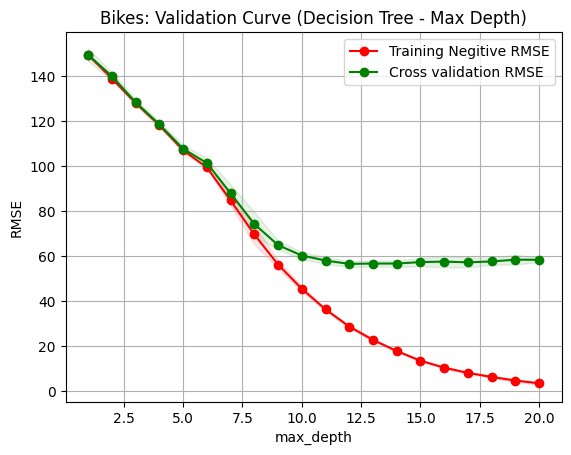

In [ ]:
plot_validation_curve(DecisionTreeRegressor(random_state=1), "Bikes: Validation Curve (Decision Tree - Max Depth)", x_train, y_train, param_range=np.arange(1, 21), param_name="max_depth")
plt.show()

### Min Samples Split

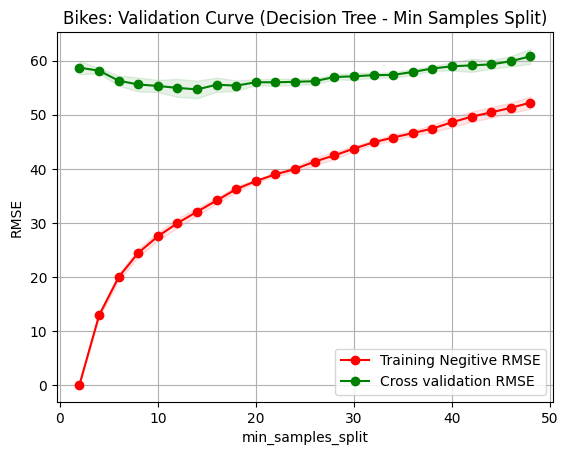

In [ ]:
plot_validation_curve(DecisionTreeRegressor(random_state=1), "Bikes: Validation Curve (Decision Tree - Min Samples Split)", x_train, y_train, param_range=np.arange(2, 50, 2), param_name="min_samples_split")
plt.show()

## Learning Curve

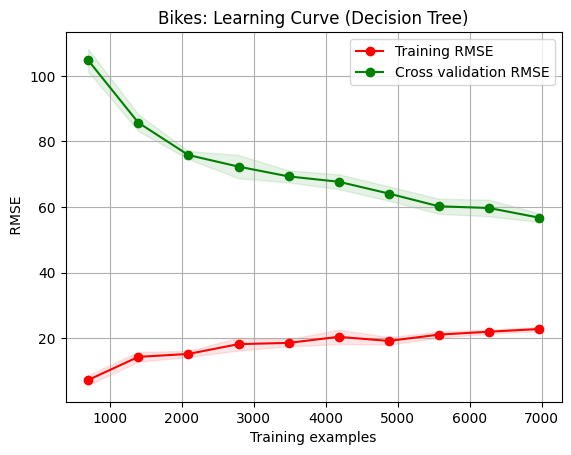

In [ ]:
plot_learning_curve(DecisionTreeRegressor(random_state=1, max_depth=13), "Bikes: Learning Curve (Decision Tree)", x_train, y_train)
plt.show()

## Evaluation

In [ ]:
dt_model = DecisionTreeRegressor(random_state=1, max_depth=13)
dt_model.fit(x_train, y_train)

DecisionTreeRegressor(random_state=1)

In [ ]:
y_pred = dt_model.predict(x_test)
print('Test Set RMSE:', np.sqrt(np.mean((y_test-y_pred)**2)))

Test Set RMSE: 57.32338628555838


#Neural Network


## Grid Search

In [ ]:
# mlp_parameters = {
#     'hidden_layer_sizes': [(50,50),(100,100),(100,50),(50,100),(200,200)],
#     'learning_rate_init': [0.001, 0.01, 0.1],
#     'alpha': [0.0001, 0.001, 0.01]
# }

# clf = GridSearchCV(MLPRegressor(random_state=1, max_iter=1000), mlp_parameters, cv=5, scoring='neg_root_mean_squared_error')
# clf.fit(x_train, y_train)
# print(clf.best_params_)

## Validation Curves/Plots

### Hidden Size

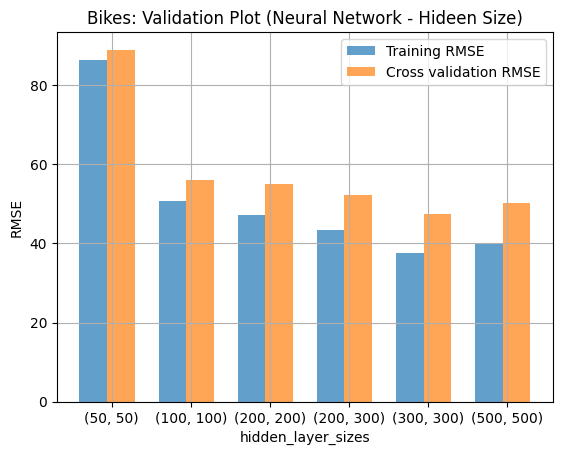

In [ ]:
plot_validation_barplot("Bikes: Validation Plot (Neural Network - Hidden Size)", x_train, y_train, parameters=[(50,50),(100,100),(200,200),(200,300),(300,300),(500,500)])
plt.show()

### Learning Rate

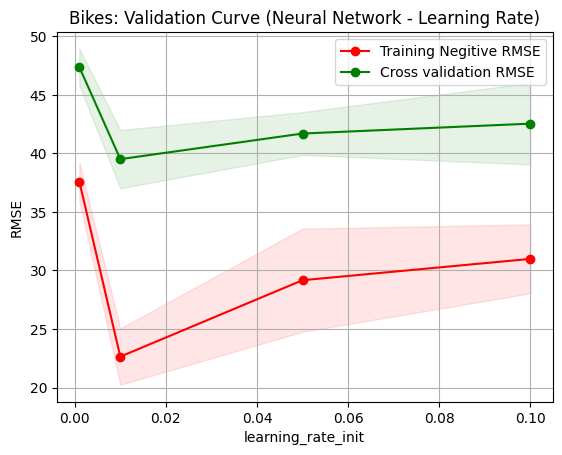

In [ ]:
plot_validation_curve(MLPRegressor(random_state=1, hidden_layer_sizes=(300,300)), "Bikes: Validation Curve (Neural Network - Learning Rate)", x_train, y_train, param_range=[0.001,0.01,0.05,0.1], param_name="learning_rate_init")
plt.show()

## Loss Curve

In [ ]:
def plot_loss_curve(estimator, title, x, y):
    plt.figure()
    plt.title(title)

    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    estimator.fit(x, y)

    plt.grid()

    plt.plot(estimator.loss_curve_)

    return plt

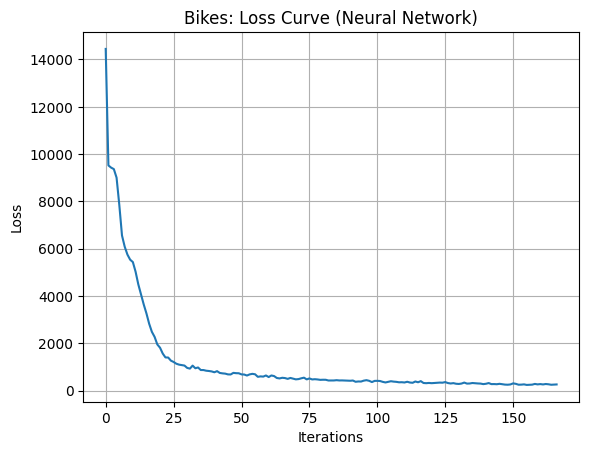

In [ ]:
plot_loss_curve(MLPRegressor(random_state=1, hidden_layer_sizes=(300,300), learning_rate_init=0.01), "Bikes: Loss Curve (Neural Network)", x_train, y_train)
plt.show()

## Evaluation

In [ ]:
nn_model = MLPRegressor(random_state=1, hidden_layer_sizes=(300,300), learning_rate_init=0.01)
nn_model.fit(x_train, y_train)

MLPRegressor(hidden_layer_sizes=(300, 300), learning_rate_init=0.01,
             random_state=1)

In [ ]:
y_pred = nn_model.predict(x_test)
print('Test Set RMSE:', np.sqrt(np.mean((y_test-y_pred)**2)))

Test Set RMSE: 41.89343477986414


#Boosting


## Grid Search

In [ ]:
# boosting_parameters = {
#     'n_estimators': [10, 100, 250],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [None, 3, 5, 10]
# }

# clf = GridSearchCV(HistGradientBoostingRegressor(), boosting_parameters, cv=5, scoring='neg_root_mean_squared_error')
# clf.fit(x_train, y_train)
# print(clf.best_params_)

## Validation Curves

### N Estimators

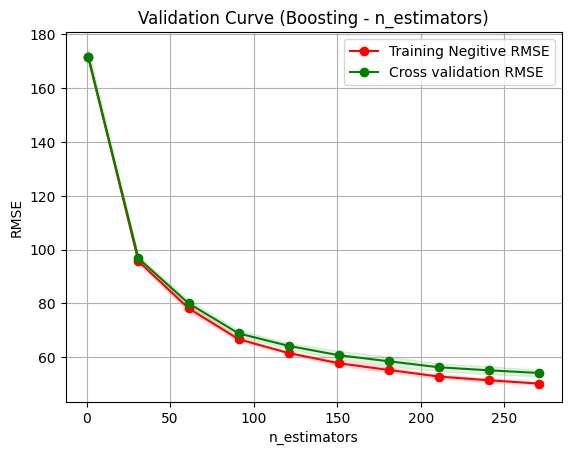

In [ ]:
plot_validation_curve(GradientBoostingRegressor(random_state=1), "Validation Curve (Boosting - n_estimators)", x_train, y_train, param_name="n_estimators", param_range=np.arange(1, 300, 30))
plt.show()

### Subsample


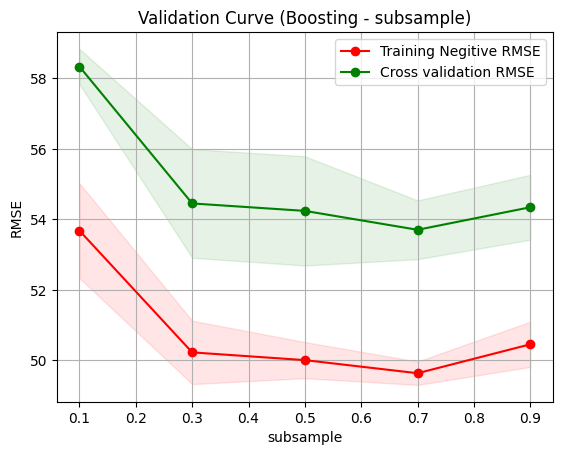

In [ ]:
plot_validation_curve(GradientBoostingRegressor(random_state=1, n_estimators=250), "Validation Curve (Boosting - subsample)", x_train, y_train, param_name="subsample", param_range=np.arange(0.1, 1, 0.2))
plt.show()

## Learning Curve

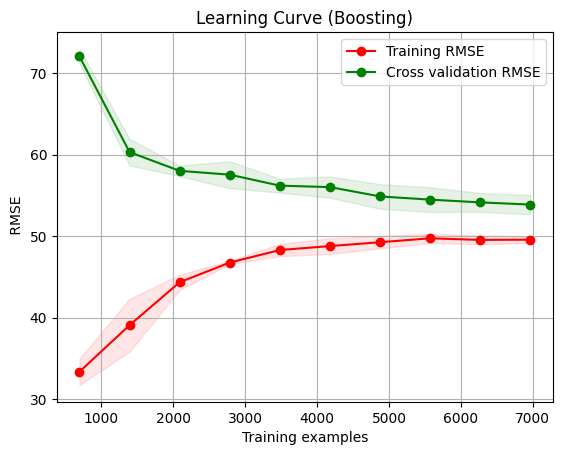

In [ ]:
plot_learning_curve(GradientBoostingRegressor(random_state=1, n_estimators=250, subsample=0.7), "Bikes: Learning Curve (Boosting)", x_train, y_train)
plt.show()

## Evaluation

In [ ]:
boosting_model = GradientBoostingRegressor(random_state=1, n_estimators=250, subsample=0.7)
boosting_model.fit(x_train, y_train)

GradientBoostingRegressor(n_estimators=250, random_state=1, subsample=0.7)

In [ ]:
y_pred = boosting_model.predict(x_test)
y_pred[y_pred<0] = 0
print('Test Set RMSE:', np.sqrt(np.mean((y_test-y_pred)**2)))

Test Set RMSE: 54.44717893967363


#Support Vector Machine

## Grid Search

In [ ]:
# sv_parameters = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': ['scale', 'auto', 0.1, 1]
# }

# clf = GridSearchCV(SVR(), sv_parameters, cv=5, scoring='neg_root_mean_squared_error')
# clf.fit(x_train, y_train)
# print(clf.best_params_)

## Validation Curves

### kernel

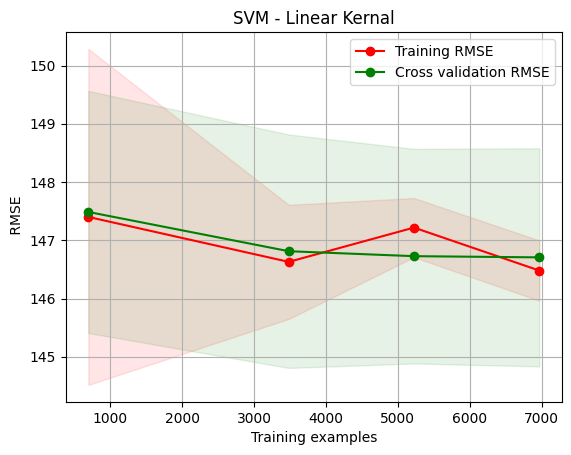

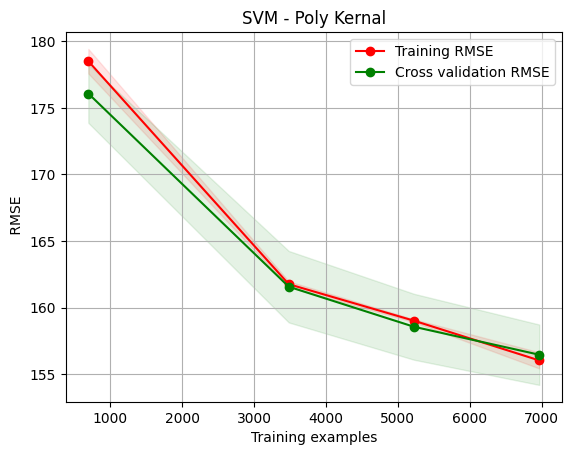

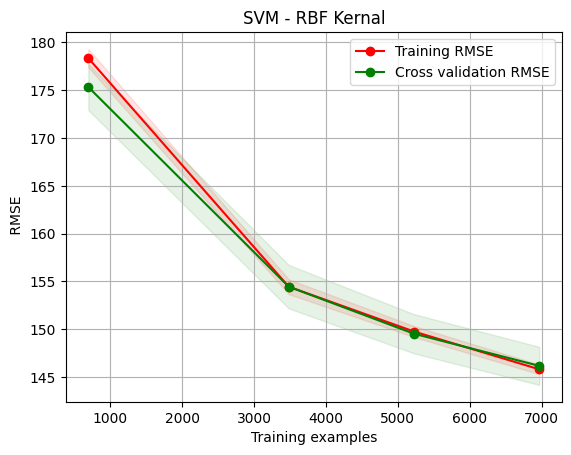

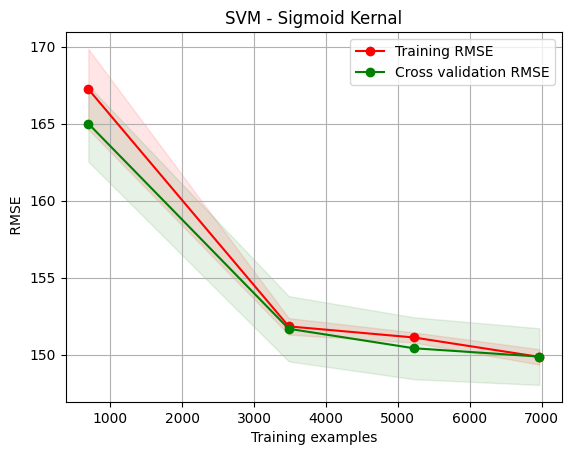

In [ ]:
plot_learning_curve(SVR(kernel ='linear'), "SVM - Linear kernel", x_train, y_train, train_sizes=[0.1,0.5,0.75,1])
plt.show()

plot_learning_curve(SVR(kernel ='poly'), "SVM - Poly kernel", x_train, y_train, train_sizes=[0.1,0.5,0.75,1])
plt.show()

plot_learning_curve(SVR(kernel ='rbf'), "SVM - RBF kernel", x_train, y_train, train_sizes=[0.1,0.5,0.75,1])
plt.show()

plot_learning_curve(SVR(kernel ='sigmoid'), "SVM - Sigmoid kernel", x_train, y_train, train_sizes=[0.1,0.5,0.75,1])
plt.show()

### C (Regularization Paramenter)

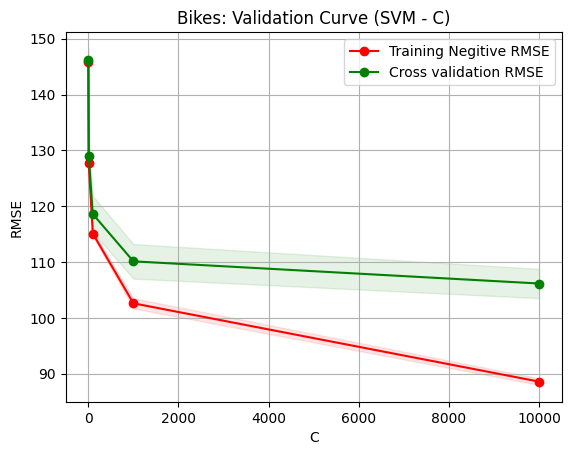

In [ ]:
plot_validation_curve(SVR(kernel ='rbf'), "Bikes: Validation Curve (SVM - C)", x_train, y_train, param_name="C", param_range=[0,1,10,100,1000,10000])
plt.show()

## Evaluation

In [ ]:
sv_model = SVR(kernel ='rbf', C=1000)
sv_model.fit(x_train, y_train)

SVR(C=1000)

In [ ]:
y_pred = sv_model.predict(x_test)
print('Test Set RMSE:', np.sqrt(np.mean((y_test-y_pred)**2)))

Test Set RMSE: 113.12052214543239


#k-Nearest Neighbor

## Grid Search

In [ ]:
# knn_parameters = {
#     'n_neighbors': [1, 5, 10],
#     'weights': ['uniform', 'distance'],
# }

# clf = GridSearchCV(KNeighborsRegressor(), knn_parameters, cv=5, scoring='neg_root_mean_squared_error')
# clf.fit(x_train, y_train)
# print(clf.best_params_)

## Validation Curves

### N Neighbors

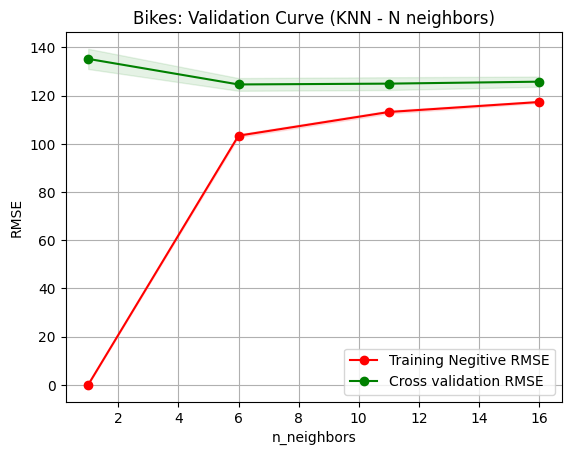

In [ ]:
plot_validation_curve(KNeighborsRegressor(), "Bikes: Validation Curve (KNN - N neighbors)", x_train, y_train, param_range=np.arange(1,21,5), param_name="n_neighbors")
plt.show()

### p (Power parameter)

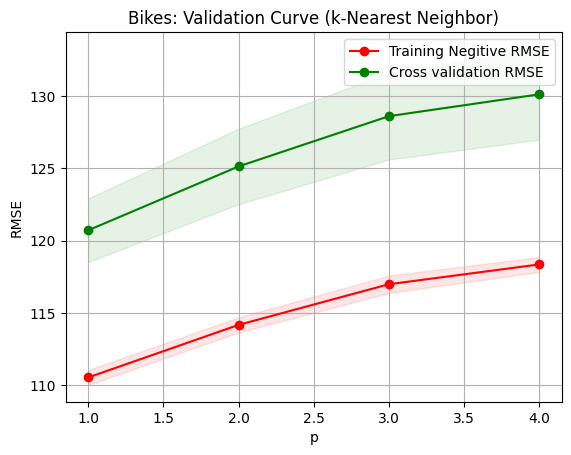

In [ ]:
plot_validation_curve(KNeighborsRegressor(n_neighbors=12), "Bikes: Validation Curve (k-Nearest Neighbor)", x_train, y_train, param_range=np.arange(1,5,1), param_name="p")
plt.show()

## Learning Curve

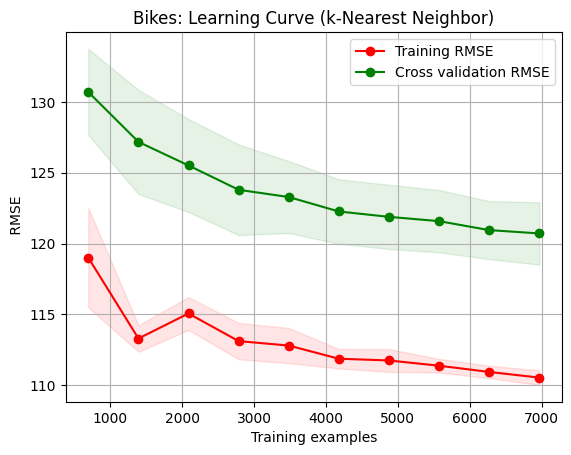

In [ ]:
plot_learning_curve(KNeighborsRegressor(n_neighbors=12, p=1), "Bikes: Learning Curve (k-Nearest Neighbor)", x_train, y_train)
plt.show()

## Evaluation

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=12, p=1)
knn_model.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=12, p=1)

In [ ]:
y_pred = knn_model.predict(x_test)
print('Test Set RMSE:', np.sqrt(np.mean((y_test-y_pred)**2)))

Test Set RMSE: 123.22802189669933


# Model Comparisons

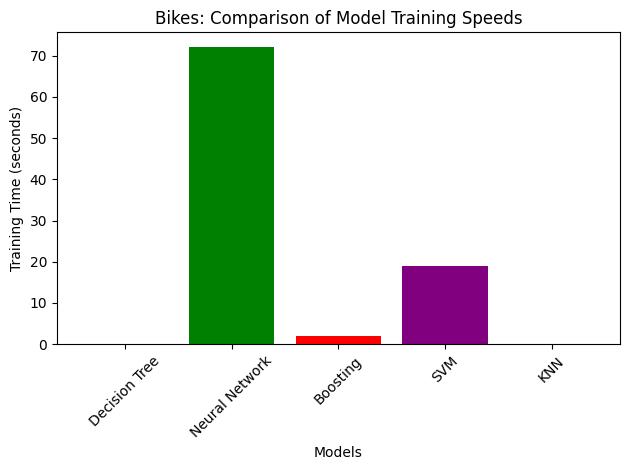

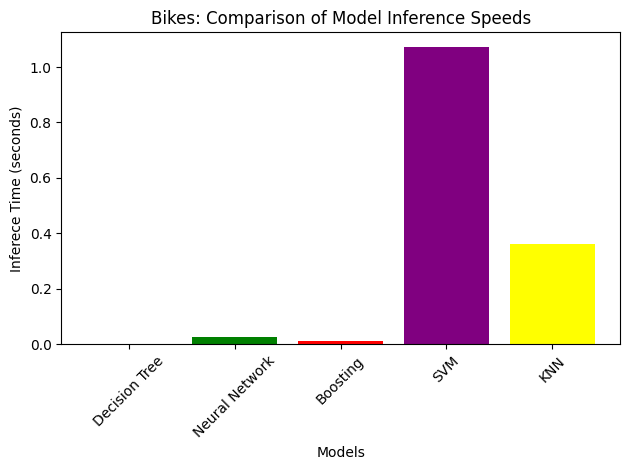

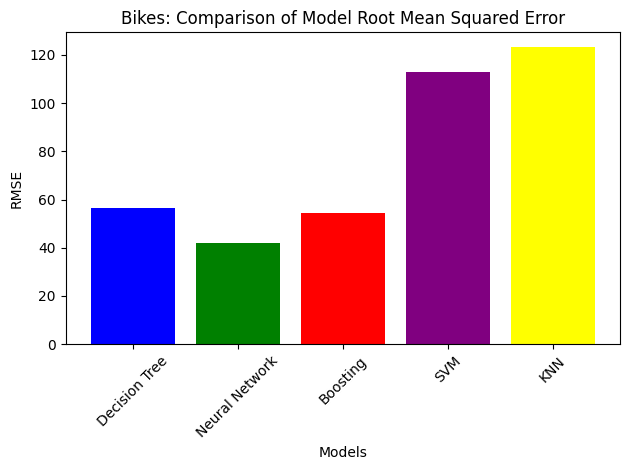

In [ ]:
compare_models()